In [1]:
# Reload all modules every time before executing the Python code typed
%load_ext autoreload
%autoreload 2

In [17]:
import os
import re
import json
from pathlib import Path
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import datetime

import cafeconmiel.data.metadata as metadata
import cafeconmiel.data.token_counts as token_counts
import cafeconmiel.utils.paths as paths_utils
import cafeconmiel.utils.metrics as metrics
import cafeconmiel.visualization.visualize as viz

from dotenv import load_dotenv
load_dotenv()

True

In [3]:
paths = paths_utils.ProjectPaths()
interim_data = paths.interim_data
raw_data = paths.raw_data

In [4]:
with open(paths.ext_data / 'corpora.json') as f:
    corpus_metadata = json.load(f)

# Load pre-processed data

Load all documents

In [5]:
corpus_name = 'all'
list_df = []
for c in corpus_metadata.keys(): # [k for k in corpus_metadata.keys() if k != 'postscriptum']:
    corpus_dir = interim_data / c
    records = []
    for path in corpus_dir.glob('*.json'):
        with open(path) as f:
            d = json.load(f)
            d['retrieved_at'] = datetime.datetime.fromtimestamp(path.stat().st_mtime)
            records.append(d)
    df = pd.DataFrame.from_records(records)
    df = df.loc[df['text'].notnull()].set_index('meta_id')
    df = metadata.normalize(df)
    df['corpus'] = c
    list_df.append(df)
auto_df = pd.concat(list_df, axis=0) # , join='inner')

In [6]:
# remove duplicates between codea and charta
auto_df = auto_df.groupby('meta_id').first().drop_duplicates()

In [7]:
auto_df['is_private'] = (
    auto_df['doc_type'].str.match('carta(s|) privada(s|)')
    | (auto_df['doc_type'] == 'epistolario')
    | auto_df['doc_type'].str.match('carta(s|) particular(es|)')
    | auto_df['doc_type'].str.match('carta(s|) personal(es|)')
    | auto_df['doc_type'].str.extract('(.*) letter,')[0].isin(
        ['personal', 'family', 'friendship', 'love']
    )
)
auto_df['is_bal'] = (auto_df['region'].str.endswith('Baleares').fillna(False)) | (auto_df['corpus'] == 'corpusmallorca')

In [8]:
auto_df.head(1)

,file_id,archive,year,locality,region,country,abstract,doc_type,text,retrieved_at,...,date,author,diplo_type,writing,materias,copyist,job,keywords,is_private,is_bal
meta_id,,,,,,,,,,,,,,,,,,,,,
AA001_01,AA001_01,Arxiu del Regne de Mallorca,1702.0,Palma,Islas Baleares,España,El procurador fiscal de la Real Audiencia de M...,informes y relaciones,\nExcelentisimo Señor\n En cumplimiento del o...,2022-07-18 16:16:39.118889,...,None,None,None,None,None,None,None,None,False,True


In [44]:
auto_df['corpus'].value_counts()

corpuscodea       4023
postscriptum      2446
corpusmallorca    1343
corpuscharta      1276
Name: corpus, dtype: int64

In [ ]:
corpus_name = 'postscriptum'
corpus_name = 'corpusmallorca'
corpus_dir = interim_data / corpus_name

In [ ]:
records = []
for path in corpus_dir.glob('*.json'):
    with open(path) as f:
        records.append(json.load(f))
auto_df = pd.DataFrame.from_records(records)
auto_df = auto_df.set_index('meta_id')
auto_df = metadata.normalize(auto_df)
auto_df.head()

,file_id,archive,year,locality,region,country,abstract,doc_type,text,format,corpus,place,date,author
meta_id,,,,,,,,,,,,,,
AMMT09_02,AMMT09_02,Arxiu Municipal de Montuïri,1787.0,Montuiri,Islas Baleares,España,Notificación a la Audiencia de la materializac...,informes y relaciones,"y Diziembre 28 de 1787. El Bayle siempre, ...",NaN,NaN,NaN,NaN,NaN
TOR01_03,TOR01_03,Arxiu del Regne de Mallorca,1688.0,Malta,Malta,Malta,Diego de Serralta escribe a su hermano Antonio...,cartas privadas,"Hermano Señor y Amigo, despues\nde 44 dias de...",NaN,NaN,NaN,NaN,NaN
TOR04_125,NaN,NaN,1862.0,Palma,Islas Baleares,NaN,"Borradores de cartas, una a Perico pidiendo no...",cartas privadas,"\n Palma 4. Abril \n Querido Perico, en \ncon...",HIPERTEXT,Corpus Mallorca,"Palma, Islas Baleares",1862- abril 4-00,xFausto Gual de Torrella (F.)
SC1_012,SC1_012,NaN,1667.0,Madrid,Madrid,España,Jordi Ferragut dice haber estado enfermo de un...,cartas privadas,Amigo y señor mio la carta de mi señor tengo r...,NaN,NaN,NaN,NaN,NaN
AA037_02,AA037_02,Arxiu del Regne de Mallorca,1804.0,Palma,Islas Baleares,España,Protesta de la Comandancia de Marina a la Audi...,informes y relaciones,Comandante militar de Marina en su precedente...,NaN,NaN,NaN,NaN,NaN


In [ ]:
auto_df.loc[(auto_df['doc_type'] == 'cartas privadas') & (auto_df['year'] >= 1600) & (auto_df['year'] < 1700)].to_csv('codea_for_conf.csv')

# Compare manually and automatically cleaned texts

In [ ]:
letters_path = paths.ext_data / 'Cartas-txt'
legal_docs_path = paths.ext_data / 'documentos arreglados CorpMA'

In [ ]:
manual_docs = {}
for fpath in letters_path.iterdir():
    match = re.match(r'.*_Lit \((.+)\)', fpath.name)
    if match is not None:
        doc_id = match.groups()[0]     
    with open(fpath, 'r') as f:
        manual_docs[doc_id] = f.read()

In [ ]:
manual_docs = {}
for fpath in legal_docs_path.iterdir():
    match = re.match(r'(.+)p.txt', fpath.name)
    if match is not None:
        doc_id = match.groups()[0]     
        with open(fpath, 'r', encoding='Windows-1252') as f:
            manual_docs[doc_id] = f.read()

In [ ]:
for doc_id, text_by_hand in manual_docs.items():
    path = interim_data / f'{doc_id}.json'
    if path.exists():
        with open(interim_data / f'{doc_id}.json', 'r') as f:
            text_auto = json.load(f)['text']
        print(f'** {doc_id} **')
        print(text_by_hand)
        print(text_auto)
        break

this is a mess, nothing corresponds

In [ ]:
real_id = 'AMPO01_01'
manual_id = 'AMPO01_03'
text_by_hand = manual_docs[manual_id]
with open(interim_data / f'{real_id}.json', 'r') as f:
    text_auto = json.load(f)['text']
print(f'** {doc_id} **')
print(text_by_hand)
print(text_auto)

did it with AMPO01_01, which corresponds partly to AMPO01_03 (last paragraph), and removing \n and spaces, I get exact match

# Get places locations

In [ ]:
from collections import defaultdict
places = defaultdict(lambda: 0)
places_dict = {}
for doc_id in doc_ids:
    with open(interim_data / f'{doc_id}.json', 'r') as f:
        p = json.load(f)['place']
        places[p] += 1
        places_dict[doc_id] = p

In [ ]:
tags = {'place': 'city'}
gdf = ox.geometries_from_place('Madrid, Madrid', tags)
gdf

/home/thomaslouf/.conda/envs/cafeconmiel/lib/python3.9/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


,,admin_level,capital,ele,is_capital,name,name:ab,name:am,name:an,name:ar,name:arc,...,source,source:date,source:ele,source:file,source:name,source:name:oc,source:population,wikidata,wikipedia,geometry
element_type,osmid,,,,,,,,,,,,,,,,,,,,,
node,21068295,2,yes,655,country,Madrid,Мaдрид,ማድሪድ,Madrit,مدريد,ܡܕܪܝܕ,...,Instituto Geográfico Nacional,2011-06,MDT5,http://centrodedescargas.cnig.es/CentroDescarg...,Nomenclátor Geográfico de Municipios y Entidad...,Lo Congrès,"BOE REAL DECRETO 1683/2007, de 14 de diciembre",Q2807,es:Madrid,POINT (-3.70358 40.41670)


# Quick viz

In [172]:
# doc_df = auto_df[['doc_type', 'year', 'text'] place_cols].copy()
doc_df = auto_df.copy()

In [103]:
figs_path = paths.proj / 'reports' / 'figures' / corpus_name
figs_path.mkdir(parents=True, exist_ok=True)

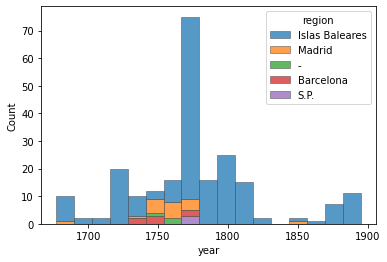

In [ ]:
top_regions = doc_df.groupby('region').size().sort_values().tail(5).index
ax = sns.histplot(
    doc_df.loc[doc_df['region'].isin(top_regions)],
    x="year", hue="region",
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,
)
ax.get_figure().savefig(figs_path / 'year_hist_by_region.pdf')

legal docs will most probably be useless, first for their content bu also region distribution: almost exclusively in baleares

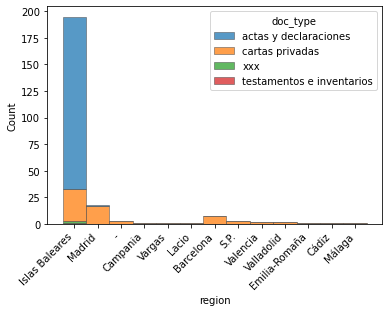

In [ ]:
ax = sns.histplot(
    doc_df,
    x="region", hue="doc_type",
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,
)
for item in ax.get_xticklabels():
    item.set_rotation(45)
    item.set_horizontalalignment('right')

ax.get_figure().savefig(figs_path / 'region_hist_by_doc_type.pdf', bbox_inches='tight')

however letters have very small year range

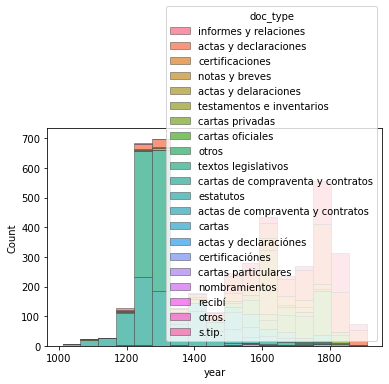

In [517]:
ax = sns.histplot(
    doc_df,
    x="year", hue="doc_type",
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,
    # legend=False
)
# ax.get_figure().savefig(figs_path / 'year_hist_by_doc_type.pdf')

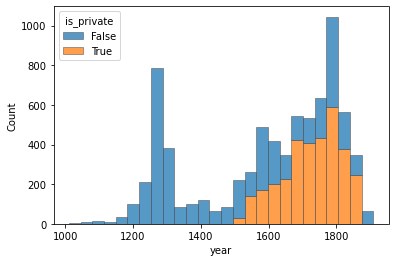

In [38]:
ax = sns.histplot(
    doc_df,
    x="year", hue="is_private",
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,
)
# ax.get_figure().savefig(figs_path / 'year_hist_private_or_not.pdf')

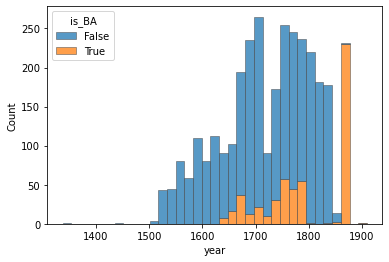

In [52]:
ax = sns.histplot(
    doc_df.loc[doc_df['is_private']],
    x="year", hue="is_bal",
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,
)

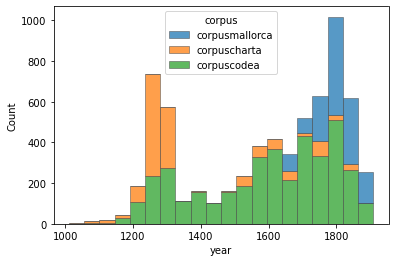

In [31]:
ax = sns.histplot(
    doc_df.loc[doc_df['corpus'] != 'postscriptum'],
    x="year", hue="corpus",
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,
)
# ax.get_figure().savefig(figs_path / 'year_hist_corpus.pdf')

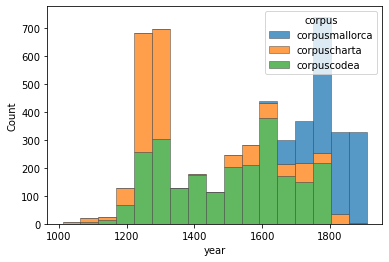

In [71]:
ax = sns.histplot(
    doc_df.loc[doc_df['corpus'] != 'postscriptum'],
    x="year", hue="corpus",
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,
)
# ax.get_figure().savefig(figs_path / 'year_hist_corpus.pdf')

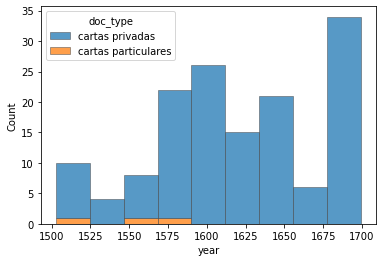

In [55]:
ax = sns.histplot(
    doc_df.loc[(doc_df['corpus'] == 'corpuscodea')
               & (doc_df['year'] > 1500)
               & (doc_df['year'] < 1700)
               & ((doc_df['doc_type'] == 'cartas privadas')
               | (doc_df['doc_type'] == 'cartas particulares'))],
    x="year", hue="doc_type",
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,
)

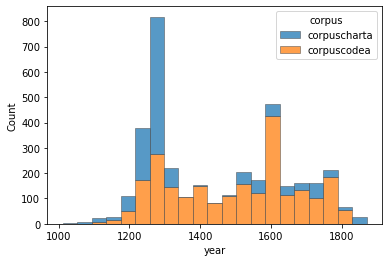

In [193]:
ax = sns.histplot(
    doc_df.loc[doc_df['corpus'] != 'corpusmallorca'],
    x="year", hue="corpus",
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,
)
ax.get_figure().savefig(figs_path / 'docs_charta-codea_time.pdf')